<a href="https://colab.research.google.com/github/MengOonLee/BertelsmannAITrack/blob/master/Generative_Adversarial_Network/CycleGAN/Yosemite_national_park.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CycleGAN, Image-to-Image Translation

In this notebook, we're going to define and train a CycleGAN to read in an image from a set $X$ and transform it so that it looks as if it belongs in set $Y$. Specifically, we'll look at a set of images of [Yosemite national park](https://en.wikipedia.org/wiki/Yosemite_National_Park) taken either during the summer or winter. The seasons are our two domains!

>The objective will be to train generators that learn to transform an image from domain $X$ into an image that looks like it came from domain $Y$ (and vice versa). 

Some examples of image data in both sets are pictured below.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/XY_season_images.png?raw=1'/>

### Unpaired Training Data

These images do not come with labels, but CycleGANs give us a way to learn the mapping between one image domain and another using an **unsupervised** approach. A CycleGAN is designed for image-to-image translation and it learns from unpaired training data. This means that in order to train a generator to translate images from domain $X$ to domain $Y$, we do not have to have exact correspondences between individual images in those domains. For example, in [the paper that introduced CycleGANs](https://arxiv.org/abs/1703.10593), the authors are able to translate between images of horses and zebras, even though there are no images of a zebra in exactly the same position as a horse or with exactly the same background, etc. Thus, CycleGANs enable learning a mapping from one domain $X$ to another domain $Y$ without having to find perfectly-matched, training pairs!

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/horse2zebra.jpg?raw=1'/>

### CycleGAN and Notebook Structure

A CycleGAN is made of two types of networks: **discriminators, and generators**. In this example, the discriminators are responsible for classifying images as real or fake (for both $X$ and $Y$ kinds of images). The generators are responsible for generating convincing, fake images for both kinds of images. 

This notebook will detail the steps you should take to define and train such a CycleGAN. 

>1. You'll load in the image data using PyTorch's DataLoader class to efficiently read in images from a specified directory. 
2. Then, you'll be tasked with defining the CycleGAN architecture according to provided specifications. You'll define the discriminator and the generator models.
3. You'll complete the training cycle by calculating the adversarial and cycle consistency losses for the generator and discriminator network and completing a number of training epochs. *It's suggested that you enable GPU usage for training.*
4. Finally, you'll evaluate your model by looking at the loss over time and looking at sample, generated images.


---

## Load and Visualize the Data

We'll first load in and visualize the training data, importing the necessary libraries to do so.

> If you are working locally, you'll need to download the data as a zip file by [clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip).

It may be named `summer2winter-yosemite` with a dash or an underscore, so take note and make sure the below `image_dir` accordingly. Then you can proceed with the following loading code.

In [1]:
%%bash

wget -qO summer2winter_yosemite.zip "https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip"
unzip -qq summer2winter_yosemite.zip
rm -rf summer2winter_yosemite.zip

replace summer2winter_yosemite/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: new name: replace mmer2winter_yosemite.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [2]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

### DataLoaders

The `get_data_loader` function returns training and test DataLoaders that can load data efficiently and in specified batches. The function has the following parameters:
* `image_type`: `summer` or `winter`,  the names of the directories where the X and Y images are stored
* `image_dir`: name of the main image directory, which holds all training and test images
* `image_size`: resized, square image dimension (all images will be resized to this dim)
* `batch_size`: number of images in one batch of data

The test data is strictly for feeding to our generators, later on, so we can visualize some generated samples on fixed, test data.

You can see that this function is also responsible for making sure our images are of the right, square size (128x128x3) and converted into Tensor image types.

**It's suggested that you use the default values of these parameters.**

Note: If you are trying this code on a different set of data, you may get better results with larger `image_size` and `batch_size` parameters. If you change the `batch_size`, make sure that you create complete batches in the training loop otherwise you may get an error when trying to save sample data. 

In [3]:
def get_data_loader(image_type, image_dir='summer2winter_yosemite', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [4]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

## Display some Training Images

Below we provide a function `imshow` that reshape some given images and converts them to NumPy images so that they can be displayed by `plt`. This cell should display a grid that contains a batch of image data from set $X$.

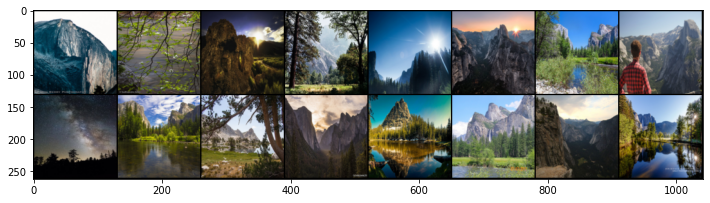

In [5]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

Next, let's visualize a batch of images from set $Y$.

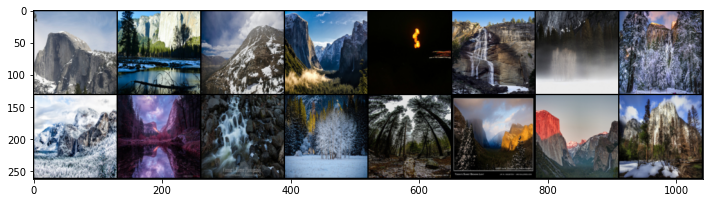

In [6]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0941)
Max:  tensor(0.9882)


In [8]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [9]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.8118)
Scaled max:  tensor(0.9765)


---
## Define the Model

A CycleGAN is made of two discriminator and two generator networks.

## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/discriminator_layers.png?raw=1'/>

This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

### Convolutional Helper Function

To define the discriminators, you're expected to use the provided `conv` function, which creates a convolutional layer + an optional batch norm layer.

In [10]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### Define the Discriminator Architecture

Your task is to fill in the `__init__` function with the specified 5 layer conv net architecture. Both $D_X$ and $D_Y$ have the same architecture, so we only need to define one class, and later instantiate two discriminators. 
> It's recommended that you use a **kernel size of 4x4** and use that to determine the correct stride and padding size for each layer. [This Stanford resource](http://cs231n.github.io/convolutional-networks/#conv) may also help in determining stride and padding sizes.

* Define your convolutional layers in `__init__`
* Then fill in the forward behavior of the network

The `forward` function defines how an input image moves through the discriminator, and the most important thing is to pass it through your convolutional layers in order, with a **ReLu** activation function applied to all but the last layer.

You should **not** apply a sigmoid activation function to the output, here, and that is because we are planning on using a squared error loss for training. And you can read more about this loss function, later in the notebook.

In [11]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value

        # Convolutional layers, increasing in depth
        # first layer has *no* batchnorm
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (32, 32, 128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (16, 16, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (8, 8, 512)
        
        # Classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        # relu applied to all conv layers but last
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        # last, classification layer
        out = self.conv5(out)
        return out

## Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning an image into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX, have the following architecture:

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/cyclegan_generator_ex.png?raw=1'/>

This network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and create a new image!

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a `tanh` activation function applied to the output. Also, the residual blocks are made of convolutional and batch normalization layers, which we'll go over in more detail, next.

---
### Residual Block Class

To define the generators, you're expected to define a `ResidualBlock` class which will help you connect the encoder and decoder portions of the generators. You might be wondering, what exactly is a Resnet block? It may sound familiar from something like ResNet50 for image classification, pictured below.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/resnet_50.png?raw=1'/>

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/resnet_block.png?raw=1'/>

### Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

#### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `conv` function from above to create this block.

In [12]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2
    

### Transpose Convolutional Helper Function

To define the generators, you're expected to use the above `conv` function, `ResidualBlock` class, and the below `deconv` helper function, which creates a transpose convolutional layer + an optional batchnorm layer.

In [13]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## Define the Generator Architecture

* Complete the `__init__` function with the specified 3 layer **encoder** convolutional net, a series of residual blocks (the number of which is given by `n_res_blocks`), and then a 3 layer **decoder** transpose convolutional net.
* Then complete the `forward` function to define the forward behavior of the generators. Recall that the last layer has a `tanh` activation function.

Both $G_{XtoY}$ and $G_{YtoX}$ have the same architecture, so we only need to define one class, and later instantiate two generators.

In [14]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        
        # initial convolutional layer given, below
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 2. Define the resnet part of the generator
        # Residual blocks
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part of the generator
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        # no batch norm on last layer
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        # tanh applied to last layer
        out = F.tanh(self.deconv3(out))

        return out

---
## Create the complete network

Using the classes you defined earlier, you can define the discriminators and generators necessary to create a complete CycleGAN. The given parameters should work for training.

First, create two discriminators, one for checking if $X$ sample images are real, and one for checking if $Y$ sample images are real. Then the generators. Instantiate two of them, one for transforming a painting into a realistic photo and one for transforming a photo into  into a painting.

In [15]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [16]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


## Check that you've implemented this correctly

The function `create_model` should return the two generator and two discriminator networks. After you've defined these discriminator and generator components, it's good practice to check your work. The easiest way to do this is to print out your model architecture and read through it to make sure the parameters are what you expected. The next cell will print out their architectures.

In [17]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv_layer1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

## Discriminator and Generator Losses

Computing the discriminator and the generator losses are key to getting a CycleGAN to train.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/CycleGAN_loss.png?raw=1'/>

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

* The CycleGAN contains two mapping functions $G: X \rightarrow Y$ and $F: Y \rightarrow X$, and associated adversarial discriminators $D_Y$ and $D_X$. **(a)** $D_Y$ encourages $G$ to translate $X$ into outputs indistinguishable from domain $Y$, and vice versa for $D_X$ and $F$.

* To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started. **(b)** Forward cycle-consistency loss and **(c)** backward cycle-consistency loss.

## Least Squares GANs

We've seen that regular GANs treat the discriminator as a classifier with the sigmoid cross entropy loss function. However, this loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, we'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and you can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training! 

### Discriminator Losses

The discriminator losses will be mean squared errors between the output of the discriminator, given an image, and the target value, 0 or 1, depending on whether it should classify that image as fake or real. For example, for a *real* image, `x`, we can train $D_X$ by looking at how close it is to recognizing and image `x` as real using the mean squared error:

```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

### Generator Losses

Calculating the generator losses will look somewhat similar to calculating the discriminator loss; there will still be steps in which you generate fake images that look like they belong to the set of $X$ images but are based on real images in set $Y$, and vice versa. You'll compute the "real loss" on those generated images by looking at the output of the discriminator as it's applied to these _fake_ images; this time, your generator aims to make the discriminator classify these fake images as *real* images. 

#### Cycle Consistency Loss

In addition to the adversarial losses, the generator loss terms will also include the **cycle consistency loss**. This loss is a measure of how good a reconstructed image is, when compared to an original image. 

Say you have a fake, generated image, `x_hat`, and a real image, `y`. You can get a reconstructed `y_hat` by applying `G_XtoY(x_hat) = y_hat` and then check to see if this reconstruction `y_hat` and the orginal image `y` match. For this, we recommed calculating the L1 loss, which is an absolute difference, between reconstructed and real images. You may also choose to multiply this loss by some weight value `lambda_weight` to convey its importance.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/reconstruction_error.png?raw=1'/>

The total generator loss will be the sum of the generator losses and the forward and backward cycle consistency losses.

---
### Define Loss Functions

To help us calculate the discriminator and gnerator losses during training, let's define some helpful loss functions. Here, we'll define three.
1. `real_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.
2. `fake_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.
3. `cycle_consistency_loss` that looks at a set of real image and a set of reconstructed/generated images, and returns the mean absolute error between them. This has a `lambda_weight` parameter that will weight the mean absolute error in a batch.

It's recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get a starting value for `lambda_weight`.

In [18]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss    


### Define the Optimizers

Next, let's define how this model will update its weights. This, like the GANs you may have seen before, uses [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) optimizers for the discriminator and generator. It's again recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get starting hyperparameter values.


In [19]:
import torch.optim as optim

# hyperparams for Adam optimizer
lr=0.0002
beta1=0.5
beta2=0.999 # default value

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

---

## Training a CycleGAN

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!


**Training the Generators**
1. Generate fake images that look like domain $X$ based on real images in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ images based on the fake $X$ images generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/cycle_consistency_ex.png?raw=1'/>


### Saving Your Progress

A CycleGAN repeats its training process, alternating between training the discriminators and the generators, for a specified number of training iterations. You've been given code that will save some example generated images that the CycleGAN has learned to generate after a certain number of training iterations. Along with looking at the losses, these example generations should give you an idea of how well your network has trained.

Below, you may choose to keep all default parameters; your only task is to calculate the appropriate losses and complete the training cycle.

In [20]:
%%file ./helpers.py

# helper functions for saving sample data and models

# import data loading libraries
import os
import pdb
import pickle
import argparse

import warnings
warnings.filterwarnings("ignore")

# import torch
import torch


# numpy & imageio imports
import numpy as np
import imageio


def checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='checkpoints_cyclegan'):
    """Saves the parameters of both generators G_YtoX, G_XtoY and discriminators D_X, D_Y.
        """
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    G_XtoY_path = os.path.join(checkpoint_dir, 'G_XtoY.pkl')
    G_YtoX_path = os.path.join(checkpoint_dir, 'G_YtoX.pkl')
    D_X_path = os.path.join(checkpoint_dir, 'D_X.pkl')
    D_Y_path = os.path.join(checkpoint_dir, 'D_Y.pkl')
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)


def merge_images(sources, targets, batch_size=16):
    """Creates a grid consisting of pairs of columns, where the first column in
        each pair contains images source images and the second column in each pair
        contains images generated by the CycleGAN from the corresponding images in
        the first column.
        """
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    merged = merged.transpose(1, 2, 0)
    return merged
    

def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

def save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='samples_cyclegan'):
    """Saves samples from both generators X->Y and Y->X.
        """
    # move input data to correct device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    fake_X = G_YtoX(fixed_Y.to(device))
    fake_Y = G_XtoY(fixed_X.to(device))
    
    X, fake_X = to_data(fixed_X), to_data(fake_X)
    Y, fake_Y = to_data(fixed_Y), to_data(fake_Y)
    
    if not os.path.exists(sample_dir):
        os.makedirs(sample_dir)
    
    merged = merge_images(X, fake_Y, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))
    
    merged = merge_images(Y, fake_X, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

Overwriting ./helpers.py


In [21]:
# import save code
from helpers import save_samples, checkpoint

In [22]:
# train the network

def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []
    
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # Train with real images
        d_x_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)
        
        # Train with fake images
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)
        

        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()

        
        ##   Second: D_Y, real and fake loss components   ##
        
        # Train with real images
        d_y_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        
        # Train with fake images

        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)


        ##    Second: generate fake Y images and reconstructed X images    ##

        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 2. Compute the generator loss based on domain Y
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Create a reconstructed x
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()


        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
        checkpoint_every=1000
        # Save the model parameters
        if epoch % checkpoint_every == 0:
            checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [23]:
n_epochs = 4000 # keep this small when testing if a model first works

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 4000] | d_X_loss: 0.3683 | d_Y_loss: 0.3003 | g_total_loss: 9.1708
Epoch [   20/ 4000] | d_X_loss: 0.8106 | d_Y_loss: 0.3792 | g_total_loss: 9.7662
Epoch [   30/ 4000] | d_X_loss: 0.5917 | d_Y_loss: 0.3516 | g_total_loss: 6.6595
Epoch [   40/ 4000] | d_X_loss: 0.5335 | d_Y_loss: 0.5109 | g_total_loss: 6.2217
Epoch [   50/ 4000] | d_X_loss: 0.4871 | d_Y_loss: 0.5198 | g_total_loss: 7.0272
Epoch [   60/ 4000] | d_X_loss: 0.4038 | d_Y_loss: 0.4793 | g_total_loss: 5.3322
Epoch [   70/ 4000] | d_X_loss: 0.3748 | d_Y_loss: 0.3370 | g_total_loss: 6.1187
Epoch [   80/ 4000] | d_X_loss: 0.2093 | d_Y_loss: 0.1629 | g_total_loss: 6.2446
Epoch [   90/ 4000] | d_X_loss: 0.4707 | d_Y_loss: 0.4217 | g_total_loss: 5.1071


Epoch [  100/ 4000] | d_X_loss: 0.3452 | d_Y_loss: 0.5330 | g_total_loss: 4.7888


Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/ 4000] | d_X_loss: 0.4452 | d_Y_loss: 0.4569 | g_total_loss: 5.8091
Epoch [  120/ 4000] | d_X_loss: 0.5447 | d_Y_loss: 0.4538 | g_total_loss: 4.4720
Epoch [  130/ 4000] | d_X_loss: 0.3076 | d_Y_loss: 0.4763 | g_total_loss: 4.4450
Epoch [  140/ 4000] | d_X_loss: 0.8038 | d_Y_loss: 0.5184 | g_total_loss: 4.3276
Epoch [  150/ 4000] | d_X_loss: 0.3294 | d_Y_loss: 0.2606 | g_total_loss: 4.9492
Epoch [  160/ 4000] | d_X_loss: 0.4057 | d_Y_loss: 0.5520 | g_total_loss: 4.9625
Epoch [  170/ 4000] | d_X_loss: 0.4242 | d_Y_loss: 0.4590 | g_total_loss: 4.2685
Epoch [  180/ 4000] | d_X_loss: 0.4454 | d_Y_loss: 0.4271 | g_total_loss: 5.1315
Epoch [  190/ 4000] | d_X_loss: 0.5099 | d_Y_loss: 0.4183 | g_total_loss: 4.0721


Epoch [  200/ 4000] | d_X_loss: 0.7121 | d_Y_loss: 0.3999 | g_total_loss: 3.6799


Saved samples_cyclegan/sample-000200-X-Y.png
Saved samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/ 4000] | d_X_loss: 0.4588 | d_Y_loss: 0.4368 | g_total_loss: 4.7887
Epoch [  220/ 4000] | d_X_loss: 0.4057 | d_Y_loss: 0.3413 | g_total_loss: 4.6148
Epoch [  230/ 4000] | d_X_loss: 0.5715 | d_Y_loss: 0.4372 | g_total_loss: 3.6488
Epoch [  240/ 4000] | d_X_loss: 0.4259 | d_Y_loss: 0.4574 | g_total_loss: 4.6599
Epoch [  250/ 4000] | d_X_loss: 0.1874 | d_Y_loss: 0.7441 | g_total_loss: 4.3752
Epoch [  260/ 4000] | d_X_loss: 0.6381 | d_Y_loss: 0.3715 | g_total_loss: 5.2727
Epoch [  270/ 4000] | d_X_loss: 0.4730 | d_Y_loss: 0.4260 | g_total_loss: 4.1978
Epoch [  280/ 4000] | d_X_loss: 0.4796 | d_Y_loss: 0.3470 | g_total_loss: 4.5335
Epoch [  290/ 4000] | d_X_loss: 0.2755 | d_Y_loss: 0.4258 | g_total_loss: 4.5308


Epoch [  300/ 4000] | d_X_loss: 0.4498 | d_Y_loss: 0.3129 | g_total_loss: 4.4074


Saved samples_cyclegan/sample-000300-X-Y.png
Saved samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/ 4000] | d_X_loss: 0.5237 | d_Y_loss: 0.2713 | g_total_loss: 4.3728
Epoch [  320/ 4000] | d_X_loss: 0.3590 | d_Y_loss: 0.4088 | g_total_loss: 5.0300
Epoch [  330/ 4000] | d_X_loss: 0.3968 | d_Y_loss: 0.4932 | g_total_loss: 5.0403
Epoch [  340/ 4000] | d_X_loss: 0.3660 | d_Y_loss: 0.5149 | g_total_loss: 4.6605
Epoch [  350/ 4000] | d_X_loss: 0.4614 | d_Y_loss: 0.6081 | g_total_loss: 4.8529
Epoch [  360/ 4000] | d_X_loss: 0.4192 | d_Y_loss: 0.3003 | g_total_loss: 4.2921
Epoch [  370/ 4000] | d_X_loss: 0.3195 | d_Y_loss: 0.5809 | g_total_loss: 5.7224
Epoch [  380/ 4000] | d_X_loss: 0.4035 | d_Y_loss: 0.3180 | g_total_loss: 4.7287
Epoch [  390/ 4000] | d_X_loss: 0.3613 | d_Y_loss: 0.5022 | g_total_loss: 4.6932


Epoch [  400/ 4000] | d_X_loss: 0.3608 | d_Y_loss: 0.3852 | g_total_loss: 4.2190


Saved samples_cyclegan/sample-000400-X-Y.png
Saved samples_cyclegan/sample-000400-Y-X.png
Epoch [  410/ 4000] | d_X_loss: 0.4348 | d_Y_loss: 0.5616 | g_total_loss: 4.6408
Epoch [  420/ 4000] | d_X_loss: 0.4743 | d_Y_loss: 0.3661 | g_total_loss: 4.3568
Epoch [  430/ 4000] | d_X_loss: 0.3004 | d_Y_loss: 0.3799 | g_total_loss: 4.3206
Epoch [  440/ 4000] | d_X_loss: 0.6582 | d_Y_loss: 0.7084 | g_total_loss: 6.3571
Epoch [  450/ 4000] | d_X_loss: 0.3590 | d_Y_loss: 0.2219 | g_total_loss: 4.9695
Epoch [  460/ 4000] | d_X_loss: 0.4511 | d_Y_loss: 0.3761 | g_total_loss: 3.9879
Epoch [  470/ 4000] | d_X_loss: 0.3773 | d_Y_loss: 0.4270 | g_total_loss: 5.2439
Epoch [  480/ 4000] | d_X_loss: 0.3093 | d_Y_loss: 0.3703 | g_total_loss: 4.4919
Epoch [  490/ 4000] | d_X_loss: 0.3221 | d_Y_loss: 0.3143 | g_total_loss: 4.6597


Epoch [  500/ 4000] | d_X_loss: 0.4443 | d_Y_loss: 0.2692 | g_total_loss: 5.5083


Saved samples_cyclegan/sample-000500-X-Y.png
Saved samples_cyclegan/sample-000500-Y-X.png
Epoch [  510/ 4000] | d_X_loss: 0.3677 | d_Y_loss: 0.8116 | g_total_loss: 3.5716
Epoch [  520/ 4000] | d_X_loss: 0.4281 | d_Y_loss: 0.3940 | g_total_loss: 3.9481
Epoch [  530/ 4000] | d_X_loss: 0.6926 | d_Y_loss: 0.2989 | g_total_loss: 4.8646
Epoch [  540/ 4000] | d_X_loss: 0.5235 | d_Y_loss: 0.4027 | g_total_loss: 4.6541
Epoch [  550/ 4000] | d_X_loss: 0.3158 | d_Y_loss: 0.4279 | g_total_loss: 4.4479
Epoch [  560/ 4000] | d_X_loss: 0.5281 | d_Y_loss: 0.3087 | g_total_loss: 3.9625
Epoch [  570/ 4000] | d_X_loss: 0.6499 | d_Y_loss: 0.4091 | g_total_loss: 3.3849
Epoch [  580/ 4000] | d_X_loss: 0.4805 | d_Y_loss: 0.4865 | g_total_loss: 3.5002
Epoch [  590/ 4000] | d_X_loss: 0.3111 | d_Y_loss: 0.1555 | g_total_loss: 4.8997


Epoch [  600/ 4000] | d_X_loss: 0.3546 | d_Y_loss: 0.4176 | g_total_loss: 4.8355


Saved samples_cyclegan/sample-000600-X-Y.png
Saved samples_cyclegan/sample-000600-Y-X.png
Epoch [  610/ 4000] | d_X_loss: 0.3891 | d_Y_loss: 0.4672 | g_total_loss: 5.2706
Epoch [  620/ 4000] | d_X_loss: 0.3658 | d_Y_loss: 0.4316 | g_total_loss: 3.7662
Epoch [  630/ 4000] | d_X_loss: 0.4002 | d_Y_loss: 0.2581 | g_total_loss: 5.0222
Epoch [  640/ 4000] | d_X_loss: 0.3964 | d_Y_loss: 0.3653 | g_total_loss: 4.4391
Epoch [  650/ 4000] | d_X_loss: 0.3814 | d_Y_loss: 0.3821 | g_total_loss: 4.0941
Epoch [  660/ 4000] | d_X_loss: 0.4653 | d_Y_loss: 0.2665 | g_total_loss: 3.6315
Epoch [  670/ 4000] | d_X_loss: 0.3633 | d_Y_loss: 0.4686 | g_total_loss: 5.2960
Epoch [  680/ 4000] | d_X_loss: 0.3347 | d_Y_loss: 0.4344 | g_total_loss: 3.3881
Epoch [  690/ 4000] | d_X_loss: 0.4220 | d_Y_loss: 0.2348 | g_total_loss: 3.5467


Epoch [  700/ 4000] | d_X_loss: 0.6701 | d_Y_loss: 0.3397 | g_total_loss: 4.7245


Saved samples_cyclegan/sample-000700-X-Y.png
Saved samples_cyclegan/sample-000700-Y-X.png
Epoch [  710/ 4000] | d_X_loss: 0.4625 | d_Y_loss: 0.3551 | g_total_loss: 3.9003
Epoch [  720/ 4000] | d_X_loss: 0.4056 | d_Y_loss: 0.4105 | g_total_loss: 4.3342
Epoch [  730/ 4000] | d_X_loss: 0.4463 | d_Y_loss: 0.3787 | g_total_loss: 3.8073
Epoch [  740/ 4000] | d_X_loss: 0.3842 | d_Y_loss: 0.4971 | g_total_loss: 4.6189
Epoch [  750/ 4000] | d_X_loss: 0.3598 | d_Y_loss: 0.3342 | g_total_loss: 3.7233
Epoch [  760/ 4000] | d_X_loss: 0.3994 | d_Y_loss: 0.3746 | g_total_loss: 4.0242
Epoch [  770/ 4000] | d_X_loss: 0.3989 | d_Y_loss: 0.4667 | g_total_loss: 3.9568
Epoch [  780/ 4000] | d_X_loss: 0.3581 | d_Y_loss: 0.5232 | g_total_loss: 4.4331
Epoch [  790/ 4000] | d_X_loss: 0.3648 | d_Y_loss: 0.3742 | g_total_loss: 4.2137


Epoch [  800/ 4000] | d_X_loss: 0.4627 | d_Y_loss: 0.3444 | g_total_loss: 3.6019


Saved samples_cyclegan/sample-000800-X-Y.png
Saved samples_cyclegan/sample-000800-Y-X.png
Epoch [  810/ 4000] | d_X_loss: 0.3194 | d_Y_loss: 0.2814 | g_total_loss: 3.9799
Epoch [  820/ 4000] | d_X_loss: 0.4134 | d_Y_loss: 0.5650 | g_total_loss: 3.5611
Epoch [  830/ 4000] | d_X_loss: 0.3984 | d_Y_loss: 0.4283 | g_total_loss: 4.5875
Epoch [  840/ 4000] | d_X_loss: 0.4290 | d_Y_loss: 0.6475 | g_total_loss: 4.0647
Epoch [  850/ 4000] | d_X_loss: 0.3634 | d_Y_loss: 0.3423 | g_total_loss: 4.0714
Epoch [  860/ 4000] | d_X_loss: 0.3222 | d_Y_loss: 0.4420 | g_total_loss: 3.5856
Epoch [  870/ 4000] | d_X_loss: 0.3842 | d_Y_loss: 0.4070 | g_total_loss: 4.3286
Epoch [  880/ 4000] | d_X_loss: 0.4786 | d_Y_loss: 0.3843 | g_total_loss: 4.1188
Epoch [  890/ 4000] | d_X_loss: 0.4016 | d_Y_loss: 0.2268 | g_total_loss: 4.4315


Epoch [  900/ 4000] | d_X_loss: 0.1365 | d_Y_loss: 0.5449 | g_total_loss: 5.1238


Saved samples_cyclegan/sample-000900-X-Y.png
Saved samples_cyclegan/sample-000900-Y-X.png
Epoch [  910/ 4000] | d_X_loss: 0.4622 | d_Y_loss: 0.2742 | g_total_loss: 4.4905
Epoch [  920/ 4000] | d_X_loss: 0.1733 | d_Y_loss: 0.3418 | g_total_loss: 4.9941
Epoch [  930/ 4000] | d_X_loss: 0.4367 | d_Y_loss: 0.3800 | g_total_loss: 5.3550
Epoch [  940/ 4000] | d_X_loss: 0.3103 | d_Y_loss: 0.2961 | g_total_loss: 3.8817
Epoch [  950/ 4000] | d_X_loss: 0.4590 | d_Y_loss: 0.4269 | g_total_loss: 3.5231
Epoch [  960/ 4000] | d_X_loss: 0.4341 | d_Y_loss: 0.3286 | g_total_loss: 4.0849
Epoch [  970/ 4000] | d_X_loss: 0.4968 | d_Y_loss: 0.3090 | g_total_loss: 3.7534
Epoch [  980/ 4000] | d_X_loss: 0.2943 | d_Y_loss: 0.2930 | g_total_loss: 4.0569
Epoch [  990/ 4000] | d_X_loss: 0.3821 | d_Y_loss: 0.4653 | g_total_loss: 3.5773


Epoch [ 1000/ 4000] | d_X_loss: 0.2838 | d_Y_loss: 0.4760 | g_total_loss: 3.8520


Saved samples_cyclegan/sample-001000-X-Y.png
Saved samples_cyclegan/sample-001000-Y-X.png
Epoch [ 1010/ 4000] | d_X_loss: 0.3720 | d_Y_loss: 0.3999 | g_total_loss: 4.7687
Epoch [ 1020/ 4000] | d_X_loss: 0.3128 | d_Y_loss: 0.4074 | g_total_loss: 4.2039
Epoch [ 1030/ 4000] | d_X_loss: 0.3635 | d_Y_loss: 0.3837 | g_total_loss: 3.9547
Epoch [ 1040/ 4000] | d_X_loss: 0.3162 | d_Y_loss: 0.3689 | g_total_loss: 4.3229
Epoch [ 1050/ 4000] | d_X_loss: 0.4097 | d_Y_loss: 0.3754 | g_total_loss: 4.3408
Epoch [ 1060/ 4000] | d_X_loss: 0.4328 | d_Y_loss: 0.3657 | g_total_loss: 4.1466
Epoch [ 1070/ 4000] | d_X_loss: 0.2287 | d_Y_loss: 0.1480 | g_total_loss: 4.0391
Epoch [ 1080/ 4000] | d_X_loss: 0.2707 | d_Y_loss: 0.4193 | g_total_loss: 4.6498
Epoch [ 1090/ 4000] | d_X_loss: 0.5351 | d_Y_loss: 0.3097 | g_total_loss: 3.9203


Epoch [ 1100/ 4000] | d_X_loss: 0.1974 | d_Y_loss: 0.1937 | g_total_loss: 4.2449


Saved samples_cyclegan/sample-001100-X-Y.png
Saved samples_cyclegan/sample-001100-Y-X.png
Epoch [ 1110/ 4000] | d_X_loss: 0.3049 | d_Y_loss: 0.2897 | g_total_loss: 5.4515
Epoch [ 1120/ 4000] | d_X_loss: 0.1833 | d_Y_loss: 0.3347 | g_total_loss: 4.4451
Epoch [ 1130/ 4000] | d_X_loss: 0.2371 | d_Y_loss: 0.1737 | g_total_loss: 4.0466
Epoch [ 1140/ 4000] | d_X_loss: 0.4228 | d_Y_loss: 0.1547 | g_total_loss: 4.0498
Epoch [ 1150/ 4000] | d_X_loss: 0.2279 | d_Y_loss: 0.6027 | g_total_loss: 3.6563
Epoch [ 1160/ 4000] | d_X_loss: 0.7859 | d_Y_loss: 0.2885 | g_total_loss: 6.3187
Epoch [ 1170/ 4000] | d_X_loss: 0.2474 | d_Y_loss: 0.2934 | g_total_loss: 4.8564
Epoch [ 1180/ 4000] | d_X_loss: 0.2262 | d_Y_loss: 0.2675 | g_total_loss: 4.3817
Epoch [ 1190/ 4000] | d_X_loss: 0.3526 | d_Y_loss: 1.0364 | g_total_loss: 3.2167


Epoch [ 1200/ 4000] | d_X_loss: 0.2126 | d_Y_loss: 0.2151 | g_total_loss: 4.4470


Saved samples_cyclegan/sample-001200-X-Y.png
Saved samples_cyclegan/sample-001200-Y-X.png
Epoch [ 1210/ 4000] | d_X_loss: 0.2906 | d_Y_loss: 0.3025 | g_total_loss: 3.8811
Epoch [ 1220/ 4000] | d_X_loss: 0.1467 | d_Y_loss: 0.3483 | g_total_loss: 5.1025
Epoch [ 1230/ 4000] | d_X_loss: 0.3069 | d_Y_loss: 0.3485 | g_total_loss: 4.4876
Epoch [ 1240/ 4000] | d_X_loss: 0.1720 | d_Y_loss: 0.2210 | g_total_loss: 3.9937
Epoch [ 1250/ 4000] | d_X_loss: 0.2688 | d_Y_loss: 0.3101 | g_total_loss: 3.9283
Epoch [ 1260/ 4000] | d_X_loss: 0.2661 | d_Y_loss: 0.6865 | g_total_loss: 3.4746
Epoch [ 1270/ 4000] | d_X_loss: 0.2417 | d_Y_loss: 0.4288 | g_total_loss: 4.4256
Epoch [ 1280/ 4000] | d_X_loss: 0.2547 | d_Y_loss: 0.2400 | g_total_loss: 4.0219
Epoch [ 1290/ 4000] | d_X_loss: 0.2049 | d_Y_loss: 0.4807 | g_total_loss: 3.2627


Epoch [ 1300/ 4000] | d_X_loss: 0.2332 | d_Y_loss: 0.2839 | g_total_loss: 5.0581


Saved samples_cyclegan/sample-001300-X-Y.png
Saved samples_cyclegan/sample-001300-Y-X.png
Epoch [ 1310/ 4000] | d_X_loss: 0.2038 | d_Y_loss: 0.2375 | g_total_loss: 3.7119
Epoch [ 1320/ 4000] | d_X_loss: 0.2983 | d_Y_loss: 0.2744 | g_total_loss: 4.2279
Epoch [ 1330/ 4000] | d_X_loss: 0.1984 | d_Y_loss: 0.1914 | g_total_loss: 3.9951
Epoch [ 1340/ 4000] | d_X_loss: 0.4369 | d_Y_loss: 0.2604 | g_total_loss: 5.4464
Epoch [ 1350/ 4000] | d_X_loss: 0.5147 | d_Y_loss: 0.2324 | g_total_loss: 3.4339
Epoch [ 1360/ 4000] | d_X_loss: 0.3466 | d_Y_loss: 0.5981 | g_total_loss: 5.8586
Epoch [ 1370/ 4000] | d_X_loss: 0.2213 | d_Y_loss: 0.2433 | g_total_loss: 4.5253
Epoch [ 1380/ 4000] | d_X_loss: 0.1329 | d_Y_loss: 0.3814 | g_total_loss: 6.4596
Epoch [ 1390/ 4000] | d_X_loss: 0.2658 | d_Y_loss: 0.1842 | g_total_loss: 4.2864


Epoch [ 1400/ 4000] | d_X_loss: 0.3748 | d_Y_loss: 0.3628 | g_total_loss: 5.8318


Saved samples_cyclegan/sample-001400-X-Y.png
Saved samples_cyclegan/sample-001400-Y-X.png
Epoch [ 1410/ 4000] | d_X_loss: 0.4654 | d_Y_loss: 0.1796 | g_total_loss: 6.5645
Epoch [ 1420/ 4000] | d_X_loss: 0.2433 | d_Y_loss: 0.2575 | g_total_loss: 3.8466
Epoch [ 1430/ 4000] | d_X_loss: 0.3021 | d_Y_loss: 0.4866 | g_total_loss: 5.5042
Epoch [ 1440/ 4000] | d_X_loss: 0.3611 | d_Y_loss: 0.1690 | g_total_loss: 3.4022
Epoch [ 1450/ 4000] | d_X_loss: 0.2446 | d_Y_loss: 0.1901 | g_total_loss: 3.5254
Epoch [ 1460/ 4000] | d_X_loss: 0.2612 | d_Y_loss: 0.2982 | g_total_loss: 5.7346
Epoch [ 1470/ 4000] | d_X_loss: 0.1692 | d_Y_loss: 0.2378 | g_total_loss: 4.6374
Epoch [ 1480/ 4000] | d_X_loss: 0.1803 | d_Y_loss: 0.3525 | g_total_loss: 6.3808
Epoch [ 1490/ 4000] | d_X_loss: 0.3998 | d_Y_loss: 0.1081 | g_total_loss: 3.9357


Epoch [ 1500/ 4000] | d_X_loss: 0.1666 | d_Y_loss: 0.2237 | g_total_loss: 4.3781


Saved samples_cyclegan/sample-001500-X-Y.png
Saved samples_cyclegan/sample-001500-Y-X.png
Epoch [ 1510/ 4000] | d_X_loss: 0.4593 | d_Y_loss: 0.2512 | g_total_loss: 4.5636
Epoch [ 1520/ 4000] | d_X_loss: 0.1351 | d_Y_loss: 0.1823 | g_total_loss: 4.4796
Epoch [ 1530/ 4000] | d_X_loss: 0.2463 | d_Y_loss: 0.2707 | g_total_loss: 3.7230
Epoch [ 1540/ 4000] | d_X_loss: 0.1648 | d_Y_loss: 0.3696 | g_total_loss: 3.6821
Epoch [ 1550/ 4000] | d_X_loss: 0.4522 | d_Y_loss: 0.2754 | g_total_loss: 4.1653
Epoch [ 1560/ 4000] | d_X_loss: 0.2148 | d_Y_loss: 0.2309 | g_total_loss: 3.8801
Epoch [ 1570/ 4000] | d_X_loss: 0.3583 | d_Y_loss: 0.2387 | g_total_loss: 4.3369
Epoch [ 1580/ 4000] | d_X_loss: 0.1602 | d_Y_loss: 0.4293 | g_total_loss: 5.0866
Epoch [ 1590/ 4000] | d_X_loss: 0.1699 | d_Y_loss: 0.2362 | g_total_loss: 4.6143


Epoch [ 1600/ 4000] | d_X_loss: 0.3085 | d_Y_loss: 0.2461 | g_total_loss: 3.9843


Saved samples_cyclegan/sample-001600-X-Y.png
Saved samples_cyclegan/sample-001600-Y-X.png
Epoch [ 1610/ 4000] | d_X_loss: 0.2103 | d_Y_loss: 0.2239 | g_total_loss: 4.8700
Epoch [ 1620/ 4000] | d_X_loss: 0.1385 | d_Y_loss: 0.1295 | g_total_loss: 5.1048
Epoch [ 1630/ 4000] | d_X_loss: 0.0663 | d_Y_loss: 0.1963 | g_total_loss: 4.0266
Epoch [ 1640/ 4000] | d_X_loss: 0.2395 | d_Y_loss: 0.2163 | g_total_loss: 4.7058
Epoch [ 1650/ 4000] | d_X_loss: 0.2786 | d_Y_loss: 0.1328 | g_total_loss: 5.0370
Epoch [ 1660/ 4000] | d_X_loss: 0.1323 | d_Y_loss: 0.1535 | g_total_loss: 4.1660
Epoch [ 1670/ 4000] | d_X_loss: 0.1830 | d_Y_loss: 0.2570 | g_total_loss: 4.6815
Epoch [ 1680/ 4000] | d_X_loss: 0.1360 | d_Y_loss: 0.1614 | g_total_loss: 3.7107
Epoch [ 1690/ 4000] | d_X_loss: 0.3595 | d_Y_loss: 0.3557 | g_total_loss: 4.4898


Epoch [ 1700/ 4000] | d_X_loss: 0.1644 | d_Y_loss: 0.3300 | g_total_loss: 4.7604


Saved samples_cyclegan/sample-001700-X-Y.png
Saved samples_cyclegan/sample-001700-Y-X.png
Epoch [ 1710/ 4000] | d_X_loss: 0.3196 | d_Y_loss: 0.2934 | g_total_loss: 4.4289
Epoch [ 1720/ 4000] | d_X_loss: 0.1117 | d_Y_loss: 0.1632 | g_total_loss: 4.5984
Epoch [ 1730/ 4000] | d_X_loss: 0.2932 | d_Y_loss: 0.1680 | g_total_loss: 3.6660
Epoch [ 1740/ 4000] | d_X_loss: 0.1709 | d_Y_loss: 0.2187 | g_total_loss: 5.0440
Epoch [ 1750/ 4000] | d_X_loss: 0.2282 | d_Y_loss: 0.4020 | g_total_loss: 4.1562
Epoch [ 1760/ 4000] | d_X_loss: 0.4485 | d_Y_loss: 0.1519 | g_total_loss: 4.1695
Epoch [ 1770/ 4000] | d_X_loss: 0.3151 | d_Y_loss: 0.0752 | g_total_loss: 3.4897
Epoch [ 1780/ 4000] | d_X_loss: 0.2705 | d_Y_loss: 0.1821 | g_total_loss: 4.0131
Epoch [ 1790/ 4000] | d_X_loss: 0.1837 | d_Y_loss: 0.1018 | g_total_loss: 4.4084


Epoch [ 1800/ 4000] | d_X_loss: 0.2523 | d_Y_loss: 0.1775 | g_total_loss: 4.3759


Saved samples_cyclegan/sample-001800-X-Y.png
Saved samples_cyclegan/sample-001800-Y-X.png
Epoch [ 1810/ 4000] | d_X_loss: 0.4565 | d_Y_loss: 0.3225 | g_total_loss: 4.0832
Epoch [ 1820/ 4000] | d_X_loss: 0.2471 | d_Y_loss: 0.2330 | g_total_loss: 4.5571
Epoch [ 1830/ 4000] | d_X_loss: 0.0679 | d_Y_loss: 0.0912 | g_total_loss: 4.4003
Epoch [ 1840/ 4000] | d_X_loss: 0.1832 | d_Y_loss: 0.0950 | g_total_loss: 3.8569
Epoch [ 1850/ 4000] | d_X_loss: 0.2232 | d_Y_loss: 0.1714 | g_total_loss: 4.2155
Epoch [ 1860/ 4000] | d_X_loss: 0.0890 | d_Y_loss: 0.0780 | g_total_loss: 4.4989
Epoch [ 1870/ 4000] | d_X_loss: 0.1415 | d_Y_loss: 0.2999 | g_total_loss: 3.2221
Epoch [ 1880/ 4000] | d_X_loss: 0.1678 | d_Y_loss: 0.2117 | g_total_loss: 4.8553
Epoch [ 1890/ 4000] | d_X_loss: 0.2097 | d_Y_loss: 0.3238 | g_total_loss: 4.0161


Epoch [ 1900/ 4000] | d_X_loss: 0.2413 | d_Y_loss: 0.1036 | g_total_loss: 4.0663


Saved samples_cyclegan/sample-001900-X-Y.png
Saved samples_cyclegan/sample-001900-Y-X.png
Epoch [ 1910/ 4000] | d_X_loss: 0.1010 | d_Y_loss: 0.2730 | g_total_loss: 4.2155
Epoch [ 1920/ 4000] | d_X_loss: 0.1484 | d_Y_loss: 0.1229 | g_total_loss: 4.3692
Epoch [ 1930/ 4000] | d_X_loss: 0.1379 | d_Y_loss: 0.1446 | g_total_loss: 4.5780
Epoch [ 1940/ 4000] | d_X_loss: 0.0640 | d_Y_loss: 0.2746 | g_total_loss: 5.0962
Epoch [ 1950/ 4000] | d_X_loss: 0.5183 | d_Y_loss: 0.1503 | g_total_loss: 3.3107
Epoch [ 1960/ 4000] | d_X_loss: 0.0355 | d_Y_loss: 0.1636 | g_total_loss: 4.7537
Epoch [ 1970/ 4000] | d_X_loss: 0.2597 | d_Y_loss: 0.1697 | g_total_loss: 3.5979
Epoch [ 1980/ 4000] | d_X_loss: 0.3067 | d_Y_loss: 0.1656 | g_total_loss: 4.5572
Epoch [ 1990/ 4000] | d_X_loss: 0.1794 | d_Y_loss: 0.2359 | g_total_loss: 4.6390


Epoch [ 2000/ 4000] | d_X_loss: 0.1334 | d_Y_loss: 0.1372 | g_total_loss: 4.1755


Saved samples_cyclegan/sample-002000-X-Y.png
Saved samples_cyclegan/sample-002000-Y-X.png
Epoch [ 2010/ 4000] | d_X_loss: 0.1261 | d_Y_loss: 0.2761 | g_total_loss: 4.0423
Epoch [ 2020/ 4000] | d_X_loss: 0.2166 | d_Y_loss: 0.1564 | g_total_loss: 4.5993
Epoch [ 2030/ 4000] | d_X_loss: 0.0793 | d_Y_loss: 0.1498 | g_total_loss: 4.7053
Epoch [ 2040/ 4000] | d_X_loss: 0.0849 | d_Y_loss: 0.1789 | g_total_loss: 4.6762
Epoch [ 2050/ 4000] | d_X_loss: 0.0831 | d_Y_loss: 0.2217 | g_total_loss: 4.5800
Epoch [ 2060/ 4000] | d_X_loss: 0.1989 | d_Y_loss: 0.1594 | g_total_loss: 4.7746
Epoch [ 2070/ 4000] | d_X_loss: 0.1068 | d_Y_loss: 0.0965 | g_total_loss: 3.8998
Epoch [ 2080/ 4000] | d_X_loss: 0.2578 | d_Y_loss: 0.1210 | g_total_loss: 4.3457
Epoch [ 2090/ 4000] | d_X_loss: 0.0826 | d_Y_loss: 0.3271 | g_total_loss: 5.3918


Epoch [ 2100/ 4000] | d_X_loss: 0.1350 | d_Y_loss: 0.3124 | g_total_loss: 5.0488


Saved samples_cyclegan/sample-002100-X-Y.png
Saved samples_cyclegan/sample-002100-Y-X.png
Epoch [ 2110/ 4000] | d_X_loss: 0.0846 | d_Y_loss: 0.1115 | g_total_loss: 4.4233
Epoch [ 2120/ 4000] | d_X_loss: 0.0686 | d_Y_loss: 0.3390 | g_total_loss: 3.8052
Epoch [ 2130/ 4000] | d_X_loss: 0.1690 | d_Y_loss: 0.0674 | g_total_loss: 3.7094
Epoch [ 2140/ 4000] | d_X_loss: 0.2905 | d_Y_loss: 0.3297 | g_total_loss: 4.3518
Epoch [ 2150/ 4000] | d_X_loss: 0.0685 | d_Y_loss: 0.1625 | g_total_loss: 4.1100
Epoch [ 2160/ 4000] | d_X_loss: 0.3617 | d_Y_loss: 0.0860 | g_total_loss: 3.8887
Epoch [ 2170/ 4000] | d_X_loss: 0.1475 | d_Y_loss: 0.0590 | g_total_loss: 3.7100
Epoch [ 2180/ 4000] | d_X_loss: 0.3619 | d_Y_loss: 0.1462 | g_total_loss: 4.5270
Epoch [ 2190/ 4000] | d_X_loss: 0.1360 | d_Y_loss: 0.0733 | g_total_loss: 4.5507


Epoch [ 2200/ 4000] | d_X_loss: 0.0418 | d_Y_loss: 0.4533 | g_total_loss: 4.6653


Saved samples_cyclegan/sample-002200-X-Y.png
Saved samples_cyclegan/sample-002200-Y-X.png
Epoch [ 2210/ 4000] | d_X_loss: 0.0898 | d_Y_loss: 0.1838 | g_total_loss: 4.4152
Epoch [ 2220/ 4000] | d_X_loss: 0.1948 | d_Y_loss: 0.1547 | g_total_loss: 4.9831
Epoch [ 2230/ 4000] | d_X_loss: 0.1636 | d_Y_loss: 0.0455 | g_total_loss: 4.9093
Epoch [ 2240/ 4000] | d_X_loss: 0.0590 | d_Y_loss: 0.0995 | g_total_loss: 4.6732
Epoch [ 2250/ 4000] | d_X_loss: 0.1212 | d_Y_loss: 0.2671 | g_total_loss: 4.7988
Epoch [ 2260/ 4000] | d_X_loss: 0.4618 | d_Y_loss: 0.0998 | g_total_loss: 5.3405
Epoch [ 2270/ 4000] | d_X_loss: 0.2083 | d_Y_loss: 0.0685 | g_total_loss: 4.1067
Epoch [ 2280/ 4000] | d_X_loss: 0.1566 | d_Y_loss: 0.0450 | g_total_loss: 4.4015
Epoch [ 2290/ 4000] | d_X_loss: 0.1076 | d_Y_loss: 0.2482 | g_total_loss: 4.9834


Epoch [ 2300/ 4000] | d_X_loss: 0.1729 | d_Y_loss: 0.3055 | g_total_loss: 3.9051


Saved samples_cyclegan/sample-002300-X-Y.png
Saved samples_cyclegan/sample-002300-Y-X.png
Epoch [ 2310/ 4000] | d_X_loss: 0.1039 | d_Y_loss: 0.1393 | g_total_loss: 4.6324
Epoch [ 2320/ 4000] | d_X_loss: 0.1485 | d_Y_loss: 0.0951 | g_total_loss: 4.3180
Epoch [ 2330/ 4000] | d_X_loss: 0.0698 | d_Y_loss: 0.4055 | g_total_loss: 4.2957
Epoch [ 2340/ 4000] | d_X_loss: 0.1699 | d_Y_loss: 0.0416 | g_total_loss: 4.2223
Epoch [ 2350/ 4000] | d_X_loss: 0.0633 | d_Y_loss: 0.1286 | g_total_loss: 4.5360
Epoch [ 2360/ 4000] | d_X_loss: 0.1125 | d_Y_loss: 0.1243 | g_total_loss: 4.3448
Epoch [ 2370/ 4000] | d_X_loss: 0.3050 | d_Y_loss: 0.2686 | g_total_loss: 3.3108
Epoch [ 2380/ 4000] | d_X_loss: 0.1277 | d_Y_loss: 0.1472 | g_total_loss: 4.5743
Epoch [ 2390/ 4000] | d_X_loss: 0.2274 | d_Y_loss: 0.0758 | g_total_loss: 4.6944


Epoch [ 2400/ 4000] | d_X_loss: 0.4062 | d_Y_loss: 0.2510 | g_total_loss: 3.5680


Saved samples_cyclegan/sample-002400-X-Y.png
Saved samples_cyclegan/sample-002400-Y-X.png
Epoch [ 2410/ 4000] | d_X_loss: 0.1634 | d_Y_loss: 0.1462 | g_total_loss: 4.1743
Epoch [ 2420/ 4000] | d_X_loss: 0.1212 | d_Y_loss: 0.1928 | g_total_loss: 5.2892
Epoch [ 2430/ 4000] | d_X_loss: 0.0648 | d_Y_loss: 0.1016 | g_total_loss: 3.9461
Epoch [ 2440/ 4000] | d_X_loss: 0.0740 | d_Y_loss: 0.1085 | g_total_loss: 4.5418
Epoch [ 2450/ 4000] | d_X_loss: 0.1468 | d_Y_loss: 0.2556 | g_total_loss: 4.5180
Epoch [ 2460/ 4000] | d_X_loss: 0.1173 | d_Y_loss: 0.0841 | g_total_loss: 4.7100
Epoch [ 2470/ 4000] | d_X_loss: 0.1393 | d_Y_loss: 0.1638 | g_total_loss: 3.7503
Epoch [ 2480/ 4000] | d_X_loss: 0.0988 | d_Y_loss: 0.2325 | g_total_loss: 3.9022
Epoch [ 2490/ 4000] | d_X_loss: 0.1950 | d_Y_loss: 0.1437 | g_total_loss: 5.2352


Epoch [ 2500/ 4000] | d_X_loss: 0.0686 | d_Y_loss: 0.3364 | g_total_loss: 6.0834


Saved samples_cyclegan/sample-002500-X-Y.png
Saved samples_cyclegan/sample-002500-Y-X.png
Epoch [ 2510/ 4000] | d_X_loss: 0.1597 | d_Y_loss: 0.1674 | g_total_loss: 4.8253
Epoch [ 2520/ 4000] | d_X_loss: 0.4539 | d_Y_loss: 0.0530 | g_total_loss: 4.3533
Epoch [ 2530/ 4000] | d_X_loss: 0.2318 | d_Y_loss: 0.1439 | g_total_loss: 4.4778
Epoch [ 2540/ 4000] | d_X_loss: 0.2181 | d_Y_loss: 0.1710 | g_total_loss: 4.9387
Epoch [ 2550/ 4000] | d_X_loss: 0.0756 | d_Y_loss: 0.1834 | g_total_loss: 3.8196
Epoch [ 2560/ 4000] | d_X_loss: 0.1497 | d_Y_loss: 0.3119 | g_total_loss: 4.5017
Epoch [ 2570/ 4000] | d_X_loss: 0.0519 | d_Y_loss: 0.1182 | g_total_loss: 4.6825
Epoch [ 2580/ 4000] | d_X_loss: 0.1023 | d_Y_loss: 0.1452 | g_total_loss: 4.0433
Epoch [ 2590/ 4000] | d_X_loss: 0.0875 | d_Y_loss: 0.0828 | g_total_loss: 4.5144


Epoch [ 2600/ 4000] | d_X_loss: 0.0375 | d_Y_loss: 0.3037 | g_total_loss: 3.8908


Saved samples_cyclegan/sample-002600-X-Y.png
Saved samples_cyclegan/sample-002600-Y-X.png
Epoch [ 2610/ 4000] | d_X_loss: 0.1663 | d_Y_loss: 0.1229 | g_total_loss: 3.8453
Epoch [ 2620/ 4000] | d_X_loss: 0.1817 | d_Y_loss: 0.0704 | g_total_loss: 4.6228
Epoch [ 2630/ 4000] | d_X_loss: 0.1553 | d_Y_loss: 0.0689 | g_total_loss: 3.8025
Epoch [ 2640/ 4000] | d_X_loss: 0.2832 | d_Y_loss: 0.0878 | g_total_loss: 4.1298
Epoch [ 2650/ 4000] | d_X_loss: 0.1922 | d_Y_loss: 0.4469 | g_total_loss: 4.3322
Epoch [ 2660/ 4000] | d_X_loss: 0.1856 | d_Y_loss: 0.0636 | g_total_loss: 5.3186
Epoch [ 2670/ 4000] | d_X_loss: 0.3527 | d_Y_loss: 0.1082 | g_total_loss: 5.0475
Epoch [ 2680/ 4000] | d_X_loss: 0.1196 | d_Y_loss: 0.0768 | g_total_loss: 4.3823
Epoch [ 2690/ 4000] | d_X_loss: 0.1203 | d_Y_loss: 0.1484 | g_total_loss: 4.4071


Epoch [ 2700/ 4000] | d_X_loss: 0.2776 | d_Y_loss: 0.1114 | g_total_loss: 4.0331


Saved samples_cyclegan/sample-002700-X-Y.png
Saved samples_cyclegan/sample-002700-Y-X.png
Epoch [ 2710/ 4000] | d_X_loss: 0.1068 | d_Y_loss: 0.1461 | g_total_loss: 4.1920
Epoch [ 2720/ 4000] | d_X_loss: 0.1180 | d_Y_loss: 0.2162 | g_total_loss: 4.3411
Epoch [ 2730/ 4000] | d_X_loss: 0.1146 | d_Y_loss: 0.1050 | g_total_loss: 4.0107
Epoch [ 2740/ 4000] | d_X_loss: 0.0613 | d_Y_loss: 0.2383 | g_total_loss: 4.0961
Epoch [ 2750/ 4000] | d_X_loss: 0.0965 | d_Y_loss: 0.1101 | g_total_loss: 4.7532
Epoch [ 2760/ 4000] | d_X_loss: 0.1267 | d_Y_loss: 0.0652 | g_total_loss: 5.0025
Epoch [ 2770/ 4000] | d_X_loss: 0.0416 | d_Y_loss: 0.2045 | g_total_loss: 4.5615
Epoch [ 2780/ 4000] | d_X_loss: 0.0331 | d_Y_loss: 0.2653 | g_total_loss: 3.7578
Epoch [ 2790/ 4000] | d_X_loss: 0.2788 | d_Y_loss: 0.0697 | g_total_loss: 4.8210


Epoch [ 2800/ 4000] | d_X_loss: 0.0715 | d_Y_loss: 0.0854 | g_total_loss: 4.0520


Saved samples_cyclegan/sample-002800-X-Y.png
Saved samples_cyclegan/sample-002800-Y-X.png
Epoch [ 2810/ 4000] | d_X_loss: 0.4468 | d_Y_loss: 0.0560 | g_total_loss: 4.9065
Epoch [ 2820/ 4000] | d_X_loss: 0.2076 | d_Y_loss: 0.2753 | g_total_loss: 4.8506
Epoch [ 2830/ 4000] | d_X_loss: 0.3598 | d_Y_loss: 0.1267 | g_total_loss: 3.6578
Epoch [ 2840/ 4000] | d_X_loss: 0.1825 | d_Y_loss: 0.0957 | g_total_loss: 3.8895
Epoch [ 2850/ 4000] | d_X_loss: 0.0944 | d_Y_loss: 0.0703 | g_total_loss: 4.5901
Epoch [ 2860/ 4000] | d_X_loss: 0.2005 | d_Y_loss: 0.2778 | g_total_loss: 5.9956
Epoch [ 2870/ 4000] | d_X_loss: 0.1874 | d_Y_loss: 0.1789 | g_total_loss: 3.5862
Epoch [ 2880/ 4000] | d_X_loss: 0.2235 | d_Y_loss: 0.1326 | g_total_loss: 3.6873
Epoch [ 2890/ 4000] | d_X_loss: 0.2937 | d_Y_loss: 0.0834 | g_total_loss: 3.8370


Epoch [ 2900/ 4000] | d_X_loss: 0.1381 | d_Y_loss: 0.2321 | g_total_loss: 4.1063


Saved samples_cyclegan/sample-002900-X-Y.png
Saved samples_cyclegan/sample-002900-Y-X.png
Epoch [ 2910/ 4000] | d_X_loss: 0.1079 | d_Y_loss: 0.1010 | g_total_loss: 4.0512
Epoch [ 2920/ 4000] | d_X_loss: 0.1353 | d_Y_loss: 0.0705 | g_total_loss: 4.6445
Epoch [ 2930/ 4000] | d_X_loss: 0.1468 | d_Y_loss: 0.0842 | g_total_loss: 4.1576
Epoch [ 2940/ 4000] | d_X_loss: 0.2284 | d_Y_loss: 0.1202 | g_total_loss: 4.1747
Epoch [ 2950/ 4000] | d_X_loss: 0.1862 | d_Y_loss: 0.0988 | g_total_loss: 4.9626
Epoch [ 2960/ 4000] | d_X_loss: 0.1560 | d_Y_loss: 0.0503 | g_total_loss: 4.8924
Epoch [ 2970/ 4000] | d_X_loss: 0.0522 | d_Y_loss: 0.2530 | g_total_loss: 4.0181
Epoch [ 2980/ 4000] | d_X_loss: 0.2882 | d_Y_loss: 0.0557 | g_total_loss: 3.2655
Epoch [ 2990/ 4000] | d_X_loss: 0.0861 | d_Y_loss: 0.3037 | g_total_loss: 3.6295


Epoch [ 3000/ 4000] | d_X_loss: 0.2022 | d_Y_loss: 0.0278 | g_total_loss: 3.9894


Saved samples_cyclegan/sample-003000-X-Y.png
Saved samples_cyclegan/sample-003000-Y-X.png
Epoch [ 3010/ 4000] | d_X_loss: 0.0571 | d_Y_loss: 0.1109 | g_total_loss: 4.3291
Epoch [ 3020/ 4000] | d_X_loss: 0.0707 | d_Y_loss: 0.0899 | g_total_loss: 3.9731
Epoch [ 3030/ 4000] | d_X_loss: 0.1280 | d_Y_loss: 0.3323 | g_total_loss: 3.9881
Epoch [ 3040/ 4000] | d_X_loss: 0.0339 | d_Y_loss: 0.1076 | g_total_loss: 4.2062
Epoch [ 3050/ 4000] | d_X_loss: 0.1006 | d_Y_loss: 0.0740 | g_total_loss: 4.8594
Epoch [ 3060/ 4000] | d_X_loss: 0.0685 | d_Y_loss: 0.2236 | g_total_loss: 4.0444
Epoch [ 3070/ 4000] | d_X_loss: 0.0558 | d_Y_loss: 0.0460 | g_total_loss: 4.2353
Epoch [ 3080/ 4000] | d_X_loss: 0.1667 | d_Y_loss: 0.0827 | g_total_loss: 4.2321
Epoch [ 3090/ 4000] | d_X_loss: 0.0906 | d_Y_loss: 0.0669 | g_total_loss: 4.4241


Epoch [ 3100/ 4000] | d_X_loss: 0.1796 | d_Y_loss: 0.1165 | g_total_loss: 3.9852


Saved samples_cyclegan/sample-003100-X-Y.png
Saved samples_cyclegan/sample-003100-Y-X.png
Epoch [ 3110/ 4000] | d_X_loss: 0.0367 | d_Y_loss: 0.1601 | g_total_loss: 4.7651
Epoch [ 3120/ 4000] | d_X_loss: 0.0563 | d_Y_loss: 0.0769 | g_total_loss: 4.4640
Epoch [ 3130/ 4000] | d_X_loss: 0.1131 | d_Y_loss: 0.1332 | g_total_loss: 4.4764
Epoch [ 3140/ 4000] | d_X_loss: 0.1654 | d_Y_loss: 0.2512 | g_total_loss: 3.2989
Epoch [ 3150/ 4000] | d_X_loss: 0.1070 | d_Y_loss: 0.0801 | g_total_loss: 4.4244
Epoch [ 3160/ 4000] | d_X_loss: 0.3363 | d_Y_loss: 0.1662 | g_total_loss: 4.4651
Epoch [ 3170/ 4000] | d_X_loss: 0.2540 | d_Y_loss: 0.0754 | g_total_loss: 4.4933
Epoch [ 3180/ 4000] | d_X_loss: 0.2306 | d_Y_loss: 0.2000 | g_total_loss: 4.2484
Epoch [ 3190/ 4000] | d_X_loss: 0.0773 | d_Y_loss: 0.0763 | g_total_loss: 3.7187


Epoch [ 3200/ 4000] | d_X_loss: 0.1504 | d_Y_loss: 0.0445 | g_total_loss: 3.8038


Saved samples_cyclegan/sample-003200-X-Y.png
Saved samples_cyclegan/sample-003200-Y-X.png
Epoch [ 3210/ 4000] | d_X_loss: 0.0450 | d_Y_loss: 0.1207 | g_total_loss: 4.6689
Epoch [ 3220/ 4000] | d_X_loss: 0.2807 | d_Y_loss: 0.1329 | g_total_loss: 3.3931
Epoch [ 3230/ 4000] | d_X_loss: 0.2473 | d_Y_loss: 0.0383 | g_total_loss: 4.1775
Epoch [ 3240/ 4000] | d_X_loss: 0.0703 | d_Y_loss: 0.1490 | g_total_loss: 4.5100
Epoch [ 3250/ 4000] | d_X_loss: 0.1199 | d_Y_loss: 0.1246 | g_total_loss: 4.5466
Epoch [ 3260/ 4000] | d_X_loss: 0.1257 | d_Y_loss: 0.0857 | g_total_loss: 4.4870
Epoch [ 3270/ 4000] | d_X_loss: 0.0415 | d_Y_loss: 0.0466 | g_total_loss: 3.7511
Epoch [ 3280/ 4000] | d_X_loss: 0.1898 | d_Y_loss: 0.0456 | g_total_loss: 3.8291
Epoch [ 3290/ 4000] | d_X_loss: 0.4979 | d_Y_loss: 0.0835 | g_total_loss: 3.9954


Epoch [ 3300/ 4000] | d_X_loss: 0.0749 | d_Y_loss: 0.1724 | g_total_loss: 3.8873


Saved samples_cyclegan/sample-003300-X-Y.png
Saved samples_cyclegan/sample-003300-Y-X.png
Epoch [ 3310/ 4000] | d_X_loss: 0.1003 | d_Y_loss: 0.0738 | g_total_loss: 4.6048
Epoch [ 3320/ 4000] | d_X_loss: 0.1614 | d_Y_loss: 0.1541 | g_total_loss: 5.4683
Epoch [ 3330/ 4000] | d_X_loss: 0.1088 | d_Y_loss: 0.1480 | g_total_loss: 4.1324
Epoch [ 3340/ 4000] | d_X_loss: 0.1544 | d_Y_loss: 0.0435 | g_total_loss: 4.3891
Epoch [ 3350/ 4000] | d_X_loss: 0.0609 | d_Y_loss: 0.1226 | g_total_loss: 4.3096
Epoch [ 3360/ 4000] | d_X_loss: 0.1780 | d_Y_loss: 0.1489 | g_total_loss: 4.2888
Epoch [ 3370/ 4000] | d_X_loss: 0.4176 | d_Y_loss: 0.1369 | g_total_loss: 3.4560
Epoch [ 3380/ 4000] | d_X_loss: 0.1492 | d_Y_loss: 0.0715 | g_total_loss: 4.5178
Epoch [ 3390/ 4000] | d_X_loss: 0.0733 | d_Y_loss: 0.5039 | g_total_loss: 3.3121


Epoch [ 3400/ 4000] | d_X_loss: 0.0703 | d_Y_loss: 0.0727 | g_total_loss: 3.6478


Saved samples_cyclegan/sample-003400-X-Y.png
Saved samples_cyclegan/sample-003400-Y-X.png
Epoch [ 3410/ 4000] | d_X_loss: 0.1706 | d_Y_loss: 0.0851 | g_total_loss: 3.7501
Epoch [ 3420/ 4000] | d_X_loss: 0.4454 | d_Y_loss: 0.1812 | g_total_loss: 3.9072
Epoch [ 3430/ 4000] | d_X_loss: 0.0618 | d_Y_loss: 0.0500 | g_total_loss: 4.1486
Epoch [ 3440/ 4000] | d_X_loss: 0.0441 | d_Y_loss: 0.1817 | g_total_loss: 3.5825
Epoch [ 3450/ 4000] | d_X_loss: 0.0314 | d_Y_loss: 0.3906 | g_total_loss: 3.8636
Epoch [ 3460/ 4000] | d_X_loss: 0.1758 | d_Y_loss: 0.2030 | g_total_loss: 4.8159
Epoch [ 3470/ 4000] | d_X_loss: 0.0717 | d_Y_loss: 0.0920 | g_total_loss: 4.1192
Epoch [ 3480/ 4000] | d_X_loss: 0.0297 | d_Y_loss: 0.1248 | g_total_loss: 4.7942
Epoch [ 3490/ 4000] | d_X_loss: 0.1308 | d_Y_loss: 0.0611 | g_total_loss: 3.7727


Epoch [ 3500/ 4000] | d_X_loss: 0.0462 | d_Y_loss: 0.1036 | g_total_loss: 4.0865


Saved samples_cyclegan/sample-003500-X-Y.png
Saved samples_cyclegan/sample-003500-Y-X.png
Epoch [ 3510/ 4000] | d_X_loss: 0.0935 | d_Y_loss: 0.0998 | g_total_loss: 3.6843
Epoch [ 3520/ 4000] | d_X_loss: 0.1328 | d_Y_loss: 0.0754 | g_total_loss: 3.5292
Epoch [ 3530/ 4000] | d_X_loss: 0.5707 | d_Y_loss: 0.0461 | g_total_loss: 3.6519
Epoch [ 3540/ 4000] | d_X_loss: 0.0897 | d_Y_loss: 0.0572 | g_total_loss: 4.0910
Epoch [ 3550/ 4000] | d_X_loss: 0.1321 | d_Y_loss: 0.1814 | g_total_loss: 4.8318
Epoch [ 3560/ 4000] | d_X_loss: 0.0583 | d_Y_loss: 0.1600 | g_total_loss: 4.1902
Epoch [ 3570/ 4000] | d_X_loss: 0.1226 | d_Y_loss: 0.0968 | g_total_loss: 4.6538
Epoch [ 3580/ 4000] | d_X_loss: 0.0875 | d_Y_loss: 0.0472 | g_total_loss: 4.2330
Epoch [ 3590/ 4000] | d_X_loss: 0.1639 | d_Y_loss: 0.1318 | g_total_loss: 4.5405


Epoch [ 3600/ 4000] | d_X_loss: 0.0528 | d_Y_loss: 0.0684 | g_total_loss: 4.5428


Saved samples_cyclegan/sample-003600-X-Y.png
Saved samples_cyclegan/sample-003600-Y-X.png
Epoch [ 3610/ 4000] | d_X_loss: 0.0819 | d_Y_loss: 0.2163 | g_total_loss: 5.1765
Epoch [ 3620/ 4000] | d_X_loss: 0.0448 | d_Y_loss: 0.0836 | g_total_loss: 4.1535
Epoch [ 3630/ 4000] | d_X_loss: 0.0923 | d_Y_loss: 0.3235 | g_total_loss: 4.0705
Epoch [ 3640/ 4000] | d_X_loss: 0.1033 | d_Y_loss: 0.0639 | g_total_loss: 4.6059
Epoch [ 3650/ 4000] | d_X_loss: 0.0416 | d_Y_loss: 0.0803 | g_total_loss: 3.8132
Epoch [ 3660/ 4000] | d_X_loss: 0.1780 | d_Y_loss: 0.2629 | g_total_loss: 4.3587
Epoch [ 3670/ 4000] | d_X_loss: 0.1653 | d_Y_loss: 0.1147 | g_total_loss: 3.8287
Epoch [ 3680/ 4000] | d_X_loss: 0.1412 | d_Y_loss: 0.1378 | g_total_loss: 4.6144
Epoch [ 3690/ 4000] | d_X_loss: 0.2367 | d_Y_loss: 0.1655 | g_total_loss: 4.6762


Epoch [ 3700/ 4000] | d_X_loss: 0.0584 | d_Y_loss: 0.1202 | g_total_loss: 5.2494


Saved samples_cyclegan/sample-003700-X-Y.png
Saved samples_cyclegan/sample-003700-Y-X.png
Epoch [ 3710/ 4000] | d_X_loss: 0.1337 | d_Y_loss: 0.1073 | g_total_loss: 4.4553
Epoch [ 3720/ 4000] | d_X_loss: 0.0912 | d_Y_loss: 0.1693 | g_total_loss: 5.6600
Epoch [ 3730/ 4000] | d_X_loss: 0.0493 | d_Y_loss: 0.2689 | g_total_loss: 4.6459
Epoch [ 3740/ 4000] | d_X_loss: 0.1145 | d_Y_loss: 0.0419 | g_total_loss: 5.0063
Epoch [ 3750/ 4000] | d_X_loss: 0.2455 | d_Y_loss: 0.1399 | g_total_loss: 5.5941
Epoch [ 3760/ 4000] | d_X_loss: 0.1466 | d_Y_loss: 0.1125 | g_total_loss: 4.1600
Epoch [ 3770/ 4000] | d_X_loss: 0.1015 | d_Y_loss: 0.0701 | g_total_loss: 4.6683
Epoch [ 3780/ 4000] | d_X_loss: 0.1655 | d_Y_loss: 0.1056 | g_total_loss: 4.5569
Epoch [ 3790/ 4000] | d_X_loss: 0.1596 | d_Y_loss: 0.0668 | g_total_loss: 4.2900


Epoch [ 3800/ 4000] | d_X_loss: 0.1955 | d_Y_loss: 0.0544 | g_total_loss: 4.2849


Saved samples_cyclegan/sample-003800-X-Y.png
Saved samples_cyclegan/sample-003800-Y-X.png
Epoch [ 3810/ 4000] | d_X_loss: 0.2130 | d_Y_loss: 0.1459 | g_total_loss: 5.6072
Epoch [ 3820/ 4000] | d_X_loss: 0.1404 | d_Y_loss: 0.1500 | g_total_loss: 4.0502
Epoch [ 3830/ 4000] | d_X_loss: 0.1156 | d_Y_loss: 0.0747 | g_total_loss: 3.6427
Epoch [ 3840/ 4000] | d_X_loss: 0.0305 | d_Y_loss: 0.0511 | g_total_loss: 4.1763
Epoch [ 3850/ 4000] | d_X_loss: 0.0207 | d_Y_loss: 0.4641 | g_total_loss: 3.6465
Epoch [ 3860/ 4000] | d_X_loss: 0.0274 | d_Y_loss: 0.0438 | g_total_loss: 3.8236
Epoch [ 3870/ 4000] | d_X_loss: 0.1255 | d_Y_loss: 0.0956 | g_total_loss: 3.5193
Epoch [ 3880/ 4000] | d_X_loss: 0.1580 | d_Y_loss: 0.0783 | g_total_loss: 3.5075
Epoch [ 3890/ 4000] | d_X_loss: 0.1321 | d_Y_loss: 0.0812 | g_total_loss: 4.5330


Epoch [ 3900/ 4000] | d_X_loss: 0.1041 | d_Y_loss: 0.0788 | g_total_loss: 4.1748


Saved samples_cyclegan/sample-003900-X-Y.png
Saved samples_cyclegan/sample-003900-Y-X.png
Epoch [ 3910/ 4000] | d_X_loss: 0.1616 | d_Y_loss: 0.3414 | g_total_loss: 5.0882
Epoch [ 3920/ 4000] | d_X_loss: 0.2338 | d_Y_loss: 0.1970 | g_total_loss: 3.8464
Epoch [ 3930/ 4000] | d_X_loss: 0.3221 | d_Y_loss: 0.0462 | g_total_loss: 4.9128
Epoch [ 3940/ 4000] | d_X_loss: 0.0676 | d_Y_loss: 0.1998 | g_total_loss: 4.9497
Epoch [ 3950/ 4000] | d_X_loss: 0.0885 | d_Y_loss: 0.0759 | g_total_loss: 4.1750
Epoch [ 3960/ 4000] | d_X_loss: 0.0610 | d_Y_loss: 0.0301 | g_total_loss: 4.0243
Epoch [ 3970/ 4000] | d_X_loss: 0.2025 | d_Y_loss: 0.0614 | g_total_loss: 4.7369
Epoch [ 3980/ 4000] | d_X_loss: 0.1244 | d_Y_loss: 0.1884 | g_total_loss: 5.2188
Epoch [ 3990/ 4000] | d_X_loss: 0.3175 | d_Y_loss: 0.1050 | g_total_loss: 3.4927


Epoch [ 4000/ 4000] | d_X_loss: 0.3648 | d_Y_loss: 0.2555 | g_total_loss: 3.0817


Saved samples_cyclegan/sample-004000-X-Y.png
Saved samples_cyclegan/sample-004000-Y-X.png


## Tips on Training and Loss Patterns

A lot of experimentation goes into finding the best hyperparameters such that the generators and discriminators don't overpower each other. It's often a good starting point to look at existing papers to find what has worked in previous experiments, I'd recommend this [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) in addition to the original [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to see what worked for them. Then, you can try your own experiments based off of a good foundation.

#### Discriminator Losses

When you display the generator and discriminator losses you should see that there is always some discriminator loss; recall that we are trying to design a model that can generate good "fake" images. So, the ideal discriminator will not be able to tell the difference between real and fake images and, as such, will always have some loss. You should also see that $D_X$ and $D_Y$ are roughly at the same loss levels; if they are not, this indicates that your training is favoring one type of discriminator over the and you may need to look at biases in your models or data.

#### Generator Loss

The generator's loss should start significantly higher than the discriminator losses because it is accounting for the loss of both generators *and* weighted reconstruction errors. You should see this loss decrease a lot at the start of training because initial, generated images are often far-off from being good fakes. After some time it may level off; this is normal since the generator and discriminator are both improving as they train. If you see that the loss is jumping around a lot, over time, you may want to try decreasing your learning rates or changing your cycle consistency loss to be a little more/less weighted.


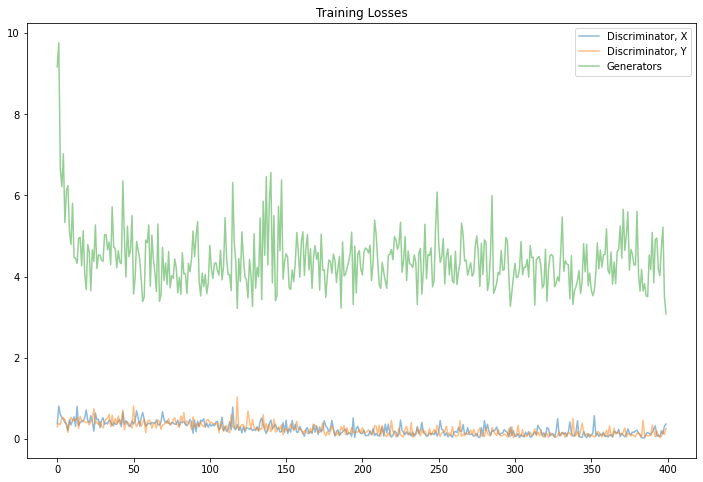

In [24]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!

As you trained this model, you may have chosen to sample and save the results of your generated images after a certain number of training iterations. This gives you a way to see whether or not your Generators are creating *good* fake images. For example, the image below depicts real images in the $Y$ set, and the corresponding generated images during different points in the training process. You can see that the generator starts out creating very noisy, fake images, but begins to converge to better representations as it trains (though, not perfect).

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/sample-004000-summer2winter.png?raw=1'/>

Below, you've been given a helper function for displaying generated samples based on the passed in training iteration.

In [25]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


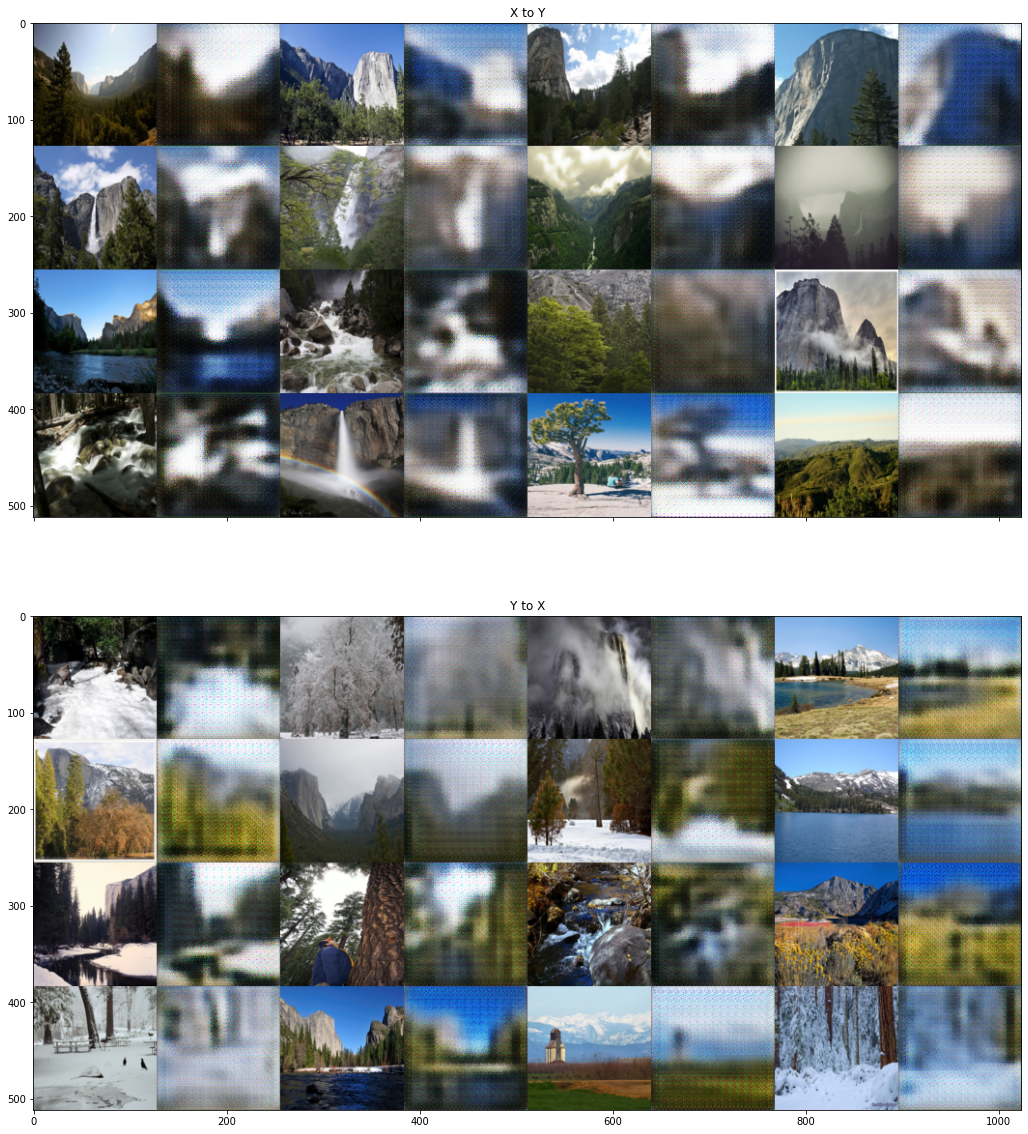

In [26]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

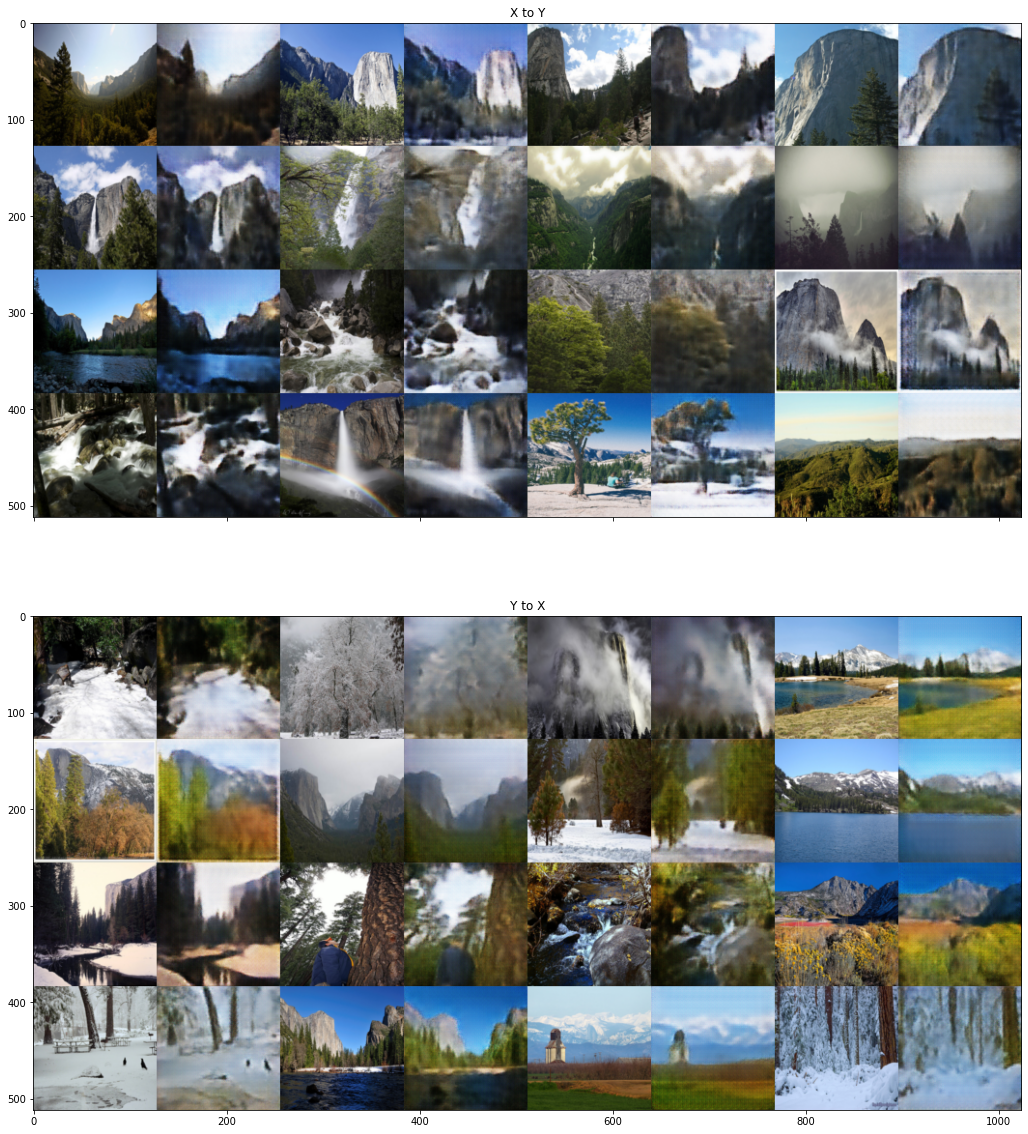

In [27]:
# view samples at iteration 4000
view_samples(4000, 'samples_cyclegan')

---
## Further Challenges and Directions

* One shortcoming of this model is that it produces fairly low-resolution images; this is an ongoing area of research; you can read about a higher-resolution formulation that uses a multi-scale generator model, in [this paper](https://arxiv.org/abs/1711.11585).
* Relatedly, we may want to process these as larger (say 256x256) images at first, to take advantage of high-res data.
* It may help your model to converge faster, if you initialize the weights in your network.
* This model struggles with matching colors exactly. This is because, if $G_{YtoX}$ and $G_{XtoY}$ may change the tint of an image; the cycle consistency loss may not be affected and can still be small. You could choose to introduce a new, color-based loss term that compares $G_{YtoX}(y)$ and $y$, and $G_{XtoY}(x)$ and $x$, but then this becomes a supervised learning approach. 
* This unsupervised approach also struggles with geometric changes, like changing the apparent size of individual object in an image, so it is best suited for stylistic transformations.
* For creating different kinds of models or trying out the Pix2Pix Architecture, [this Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/) which implements CycleGAN *and* Pix2Pix in PyTorch is a great resource.

**Once you are satified with your model, you are ancouraged to test it on a different dataset to see if it can find different types of mappings!**

---

### Different datasets for download

You can download a variety of datasets used in the Pix2Pix and CycleGAN papers, by following instructions in the [associated Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/README.md). You'll just need to make sure that the data directories are named and organized correctly to load in that data.